In [1]:
import datetime
import os
import time
import pickle
import wandb
import cv2

import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.compat.v1 as tfc
import numpy as np

from PIL import Image,ImageOps
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
from keras.callbacks import TensorBoard
from keras import callbacks
from sklearn.metrics import confusion_matrix
from wandb.keras import WandbCallback

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_name = tf.test.gpu_device_name()
if not device_name:
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
gpu_options= tfc.GPUOptions(per_process_gpu_memory_fraction = 0.8)

try: sess.close() 
except: pass
sess = tfc.InteractiveSession(config=tfc.ConfigProto(gpu_options=gpu_options))
tf.executing_eagerly()


Num GPUs Available:  1
Found GPU at: /device:GPU:0


True

## CONSTANTS

In [3]:
IMG_SIZE = 128
CHANNELS = 1
#INPUT_SHAPE = [IMG_SIZE,int(IMG_SIZE/2),3]
INPUT_SHAPE = [IMG_SIZE,IMG_SIZE,CHANNELS]

BATCH_SIZE = 64
EPOCHS = 300

ROT= 20


NAME = f"O_CNN{int(time.time())}"
SOURCE = "train_images/"
RES = f"train_images_res_{INPUT_SHAPE[0]}x{INPUT_SHAPE[1]}/"

### TensorBoard + Callbacks

In [4]:
#wandb.tensorboard.patch(root_logdir="logs/")

In [5]:
#%load_ext tensorboard
#%tensorboard --logdir logs

earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 15, 
                                        restore_best_weights = True)

## Adjust CSV

In [6]:
#adjust names to fit
train_csv = "train.csv"
train_df = pd.read_csv(train_csv)
train_df.species.replace({"globis": "short_finned_pilot_whale",
                          "pilot_whale": "short_finned_pilot_whale",
                          "kiler_whale": "killer_whale",
                          "bottlenose_dolpin": "bottlenose_dolphin"}, inplace=True)

all_species_labels = list(train_df.species.unique())
images = train_df['image']
sid = train_df['individual_id']
train_df

,image,species,individual_id
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9
1,000562241d384d.jpg,humpback_whale,1a71fbb72250
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392
...,...,...,...
51028,fff639a7a78b3f.jpg,beluga,5ac053677ed1
51029,fff8b32daff17e.jpg,cuviers_beaked_whale,1184686361b3
51030,fff94675cc1aef.jpg,blue_whale,5401612696b9
51031,fffbc5dd642d8c.jpg,beluga,4000b3d7c24e


amount of species: 26


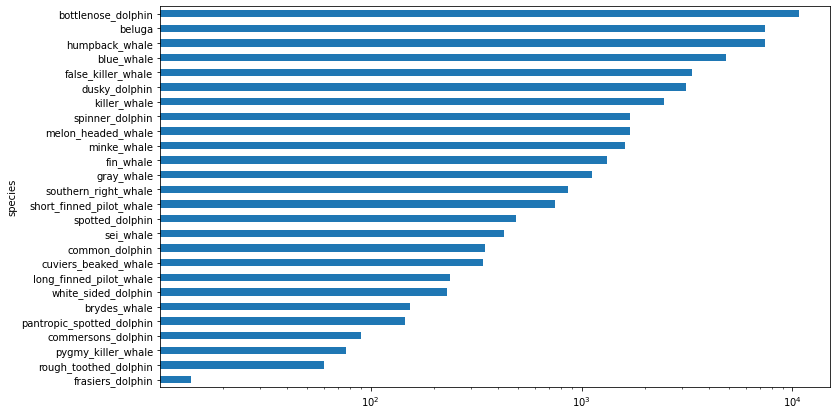

In [7]:
print(f"amount of species: {len(train_df.species.unique())}")
plt.figure(figsize=(12, 7))
train_df.groupby(by='species').size().sort_values().plot.barh().set_xscale('log')

#### Adjust for class imbalance

In [8]:
thresh = 1000
max_instances = 5000

#train_df.species = train_df.species.apply(lambda x: 'other_dolphin' if ('dolphin' in x and not "bottlenose" in x) else x)
species_counts = train_df['species'].value_counts()



final_species = species_counts[species_counts > thresh].index.tolist()
undersample_species = species_counts[species_counts > max_instances].index.tolist()
mask = train_df.species.apply(lambda x: any(item for item in final_species if item in x))
final_df = train_df[mask]

In [9]:
def undersample(df, index, max_instances):
    sampled = df[df.species == index].sample(n=max_instances, random_state=101) if len(df[df.species == index]) > max_instances else df[df.species == index]
    return  sampled

dfs = []
for species in final_species:
    dfs.append(undersample(final_df,species,max_instances))

final_train_df = pd.concat(dfs,axis=0).sort_index()
final_train_df["species"].value_counts()

train_df=final_train_df
species_labels = list(train_df.species.unique())

In [10]:
def get_id(sp):
    return species_labels.index(sp)
##encode species
names = train_df["species"].unique()
train_df["species"] = train_df.apply(lambda row :get_id(row["species"]),axis = 1)
labels = train_df["species"]

AMT_CLASSES = len(labels.unique())

In [11]:
train_df

,image,species,individual_id
0,00021adfb725ed.jpg,0,cadddb1636b9
1,000562241d384d.jpg,1,1a71fbb72250
2,0007c33415ce37.jpg,2,60008f293a2b
3,0007d9bca26a99.jpg,3,4b00fe572063
6,000be9acf46619.jpg,4,afb9b3978217
...,...,...,...
51024,fff4686bea76f0.jpg,2,be2aa86d0e5b
51026,fff54859cb0beb.jpg,2,b90d49ab0905
51027,fff603f5af8614.jpg,6,40fe65946167
51028,fff639a7a78b3f.jpg,4,5ac053677ed1


In [12]:
print(labels.unique())
print(names)

[ 0  1  2  3  4  5  6  7  8  9 10 11]
['melon_headed_whale' 'humpback_whale' 'false_killer_whale'
 'bottlenose_dolphin' 'beluga' 'minke_whale' 'fin_whale' 'blue_whale'
 'gray_whale' 'killer_whale' 'dusky_dolphin' 'spinner_dolphin']


In [13]:
##one-hot encode species
"""
labels = pd.get_dummies(train_df.species, prefix='species_')
labels
train_df = pd.concat([train_df,labels],axis = 1)

val_counts = []
for sp in labels.columns:
    val_counts.append(labels[sp].value_counts()[1])
print(val_counts)

AMT_CLASSES = labels.shape[1]
"""

"\nlabels = pd.get_dummies(train_df.species, prefix='species_')\nlabels\ntrain_df = pd.concat([train_df,labels],axis = 1)\n\nval_counts = []\nfor sp in labels.columns:\n    val_counts.append(labels[sp].value_counts()[1])\nprint(val_counts)\n\nAMT_CLASSES = labels.shape[1]\n"

## Resize Images
This helps the model fitting --> picture preprocessing gets less intensive

In [14]:
def image_filet(im):
    #Kernel exclusion and image processing
    img = np.asarray(im)
    gauss = cv2.GaussianBlur(img, (0, 0), 2.0)
    img = cv2.addWeighted(img, 1, gauss, 0, 0)
    
    img = cv2.GaussianBlur(img,(9,9),2.0)
    kernel = np.array([[0,-1,0], [-1,6,-1], [0,-1,0]])
    img = cv2.filter2D(img, -1, kernel)
    return Image.fromarray(img)


if not os.path.exists(RES):
    os.mkdir(RES)
    for image in tqdm(images):
        savePath = RES + image  
        if not os.path.exists(savePath):
            imgPath = SOURCE + image
            im = Image.open(imgPath)
            im = ImageOps.grayscale(im) if CHANNELS == 1 else im
            
            #im = image_filet(im)
            
            #im.thumbnail((IMG_SIZE,IMG_SIZE), Image.ANTIALIAS)
            #im = ImageOps.pad(im, (IMG_SIZE,IMG_SIZE), color='black')
            #im.save(savePath)
            
            resizedImage = im.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
            resizedImage.save(savePath) 
            

In [15]:
full_img = list(map(RES.__add__,train_df['image']))

## Input Pipeline

In [16]:
@tf.function
def process_tuple(image,label):
    img = tf.io.read_file(image)
    img = tf.image.decode_jpeg(img, channels=CHANNELS)
    
    img = tf.image.random_flip_left_right(img)
    lower,upper = 0.1,0.5
    img = tf.image.random_contrast(img, lower, upper, seed=None)

    img = tf.image.convert_image_dtype(img, tf.float16)
    return img, label

In [17]:
TRAIN_SPLIT = 0.7
VAL_TEST_SPLIT = (1-TRAIN_SPLIT)/2

In [18]:
dataset = tf.data.Dataset.from_tensor_slices((full_img, labels)).shuffle(BATCH_SIZE).map(process_tuple,num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)

image_count = dataset.cardinality().numpy()
train_size = int(image_count*TRAIN_SPLIT)
val_test_size = int(image_count*VAL_TEST_SPLIT)


train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size).take(val_test_size)
test_ds = dataset.skip(train_size).skip(val_test_size)

In [19]:
"""
label_dss = []
val_ds, test_ds = None, None
comp_tr, comp_vt = 0, 0

for label in labels.columns:
    query = train_df.query(f"{label} == 1")
    query = query.sample(frac = thresh/len(query), replace = True)
    
    
    img_paths = list(map(RES.__add__,query['image']))
    
    tr_size = int(len(query)*TRAIN_SPLIT)
    comp_tr += tr_size
    vt_size = int(len(query)*VAL_TEST_SPLIT)-1
    comp_vt += vt_size
    
    label_ds = tf.data.Dataset.from_tensor_slices((img_paths, query[labels.columns])).map(process_tuple,num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
    val_ds = label_ds.skip(tr_size).take(vt_size) if not val_ds else val_ds.concatenate(label_ds.skip(tr_size).take(vt_size))
    test_ds = label_ds.skip(tr_size).skip(vt_size) if not test_ds else test_ds.concatenate(label_ds.skip(tr_size).skip(vt_size))

    label_dss.append(label_ds.take(tr_size))

    
train_ds = tf.data.Dataset.sample_from_datasets(label_dss, weights=[1/len(label_dss)]*len(label_dss))
"""

'\nlabel_dss = []\nval_ds, test_ds = None, None\ncomp_tr, comp_vt = 0, 0\n\nfor label in labels.columns:\n    query = train_df.query(f"{label} == 1")\n    query = query.sample(frac = thresh/len(query), replace = True)\n    \n    \n    img_paths = list(map(RES.__add__,query[\'image\']))\n    \n    tr_size = int(len(query)*TRAIN_SPLIT)\n    comp_tr += tr_size\n    vt_size = int(len(query)*VAL_TEST_SPLIT)-1\n    comp_vt += vt_size\n    \n    label_ds = tf.data.Dataset.from_tensor_slices((img_paths, query[labels.columns])).map(process_tuple,num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)\n    val_ds = label_ds.skip(tr_size).take(vt_size) if not val_ds else val_ds.concatenate(label_ds.skip(tr_size).take(vt_size))\n    test_ds = label_ds.skip(tr_size).skip(vt_size) if not test_ds else test_ds.concatenate(label_ds.skip(tr_size).skip(vt_size))\n\n    label_dss.append(label_ds.take(tr_size))\n\n    \ntrain_ds = tf.data.Dataset.sample_from_datasets(label_dss, weights=[1/len(label_dss)]

In [20]:
train_batched = train_ds.batch(batch_size=BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
val_batched = val_ds.batch(batch_size=int(BATCH_SIZE*VAL_TEST_SPLIT)).cache().prefetch(tf.data.AUTOTUNE)
test_batched = test_ds.batch(batch_size=BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

### Benchmark Dataset

In [21]:
#nocnn = new_cnn_oliver.create_model(INPUT_SHAPE, AMT_CLASSES)
def benchmark(dataset, num_epochs=2):
    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        for sample in tqdm(dataset):
            # Performing a training step
            time.sleep(0.01)
    print("Execution time:", time.perf_counter() - start_time)

In [22]:
benchmark_ds = train_ds.take(1)
benchmark(benchmark_ds)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.11it/s]

Execution time: 0.1420572999995784


## Modelling

#### WandB

In [23]:
run = wandb.init(project="my-test-project",
           entity="dolphin_project",
           sync_tensorboard = True,
           config={
               "learning_rate": 0.005,
               "batch_size": BATCH_SIZE,
               "epochs": EPOCHS,
               "input_width": INPUT_SHAPE[0],
               "input_height": INPUT_SHAPE[1],
               "loss_function": "sparse_categorical_crossentropy",
               "architecture": "CNN",
               "dataset": "dolphin",
               #"activation": ACTIVATION_STR,
               #"conv_units": [FIRST_CONV_UNITS, SECOND_CONV_UNITS] + CONV_UNITS_BODY,
           })
config = wandb.config

wandb: Currently logged in as: dolphin_project (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


#### Model Keras

In [24]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight = 'balanced', classes = labels.unique(), y=labels)
class_weights = dict(enumerate(class_weights))

In [25]:
#import model generators
import stefan_cnn_v3
#import stefan_cnn_v2
#import oliver_cnn_v1
import sequential_nn
import sequential_nn_c
#import new_cnn_oliver
#import berkan_cnn

In [26]:
tf.keras.backend.clear_session()

#ocnn = oliver_cnn_v1.create_model(INPUT_SHAPE, AMT_CLASSES)
scnn = stefan_cnn_v3.create_model(INPUT_SHAPE, AMT_CLASSES)
#nocnn = new_cnn_oliver.create_model(INPUT_SHAPE, AMT_CLASSES)
seqnn = sequential_nn.create_model(INPUT_SHAPE, AMT_CLASSES)
#nseqnn = sequential_nn.create_model(INPUT_SHAPE, AMT_CLASSES)
#bcnn = berkan_cnn.create_model(INPUT_SHAPE, AMT_CLASSES)

current_model = scnn
    
current_model.summary()
current_model.compile(loss=config.loss_function,#tfa.losses.SigmoidFocalCrossEntropy()
             optimizer=keras.optimizers.Adam(config.learning_rate),
             metrics=['accuracy']) 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        multiple             0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 16)   160         ['sequential[0][0]']             
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 16)  64          ['conv2d[0][0]']             

 rmalization)                                                                                     
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 8, 8, 256)   0           ['batch_normalization_9[0][0]']  
                                                                                                  
 flatten (Flatten)              (None, 16384)        0           ['max_pooling2d_2[0][0]']        
                                                                                                  
 dropout_3 (Dropout)            (None, 16384)        0           ['flatten[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 12)           196620      ['dropout_3[0][0]']              
                                                                                                  
Total para

In [ ]:
history = current_model.fit(train_batched,
                    class_weight = class_weights,
                    epochs = EPOCHS,
                    validation_data = val_batched,
                    callbacks=[WandbCallback(input_type="image",  labels=names),
                              TensorBoard(log_dir=wandb.run.dir),
                              #WandbClassificationCallback(log_confusion_matrix=True, validation_data=val_batched, labels=list(range(AMT_CLASSES))),
                              earlystopping                           
                             ])
wandb.watch(history)

Epoch 1/300
 45/396 [==>...........................] - ETA: 6:58 - loss: 15.3391 - accuracy: 0.2170

In [29]:
pr = current_model.predict(test_batched)

In [52]:
y_test = np.array(labels)[train_size+val_test_size:]
y_pred = pr.argmax(axis=1)
#y_act = y_test.values.argmax(axis=1)
y_act = y_test

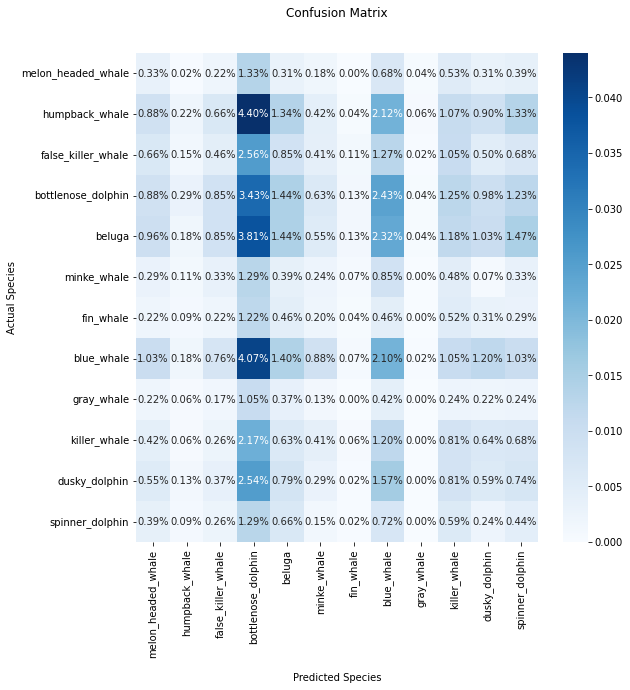

In [53]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#sp_list = list(map(lambda x: x.split("species__")[-1],labels))

cm=confusion_matrix(y_act,y_pred)

plt.figure(figsize=(9, 9))
ax = sns.heatmap(cm/np.sum(cm), annot=True,fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Species')
ax.set_ylabel('Actual Species')

ax.xaxis.set_ticklabels(names,rotation = 90)
ax.yaxis.set_ticklabels(names, rotation = 360)


plt.show()

In [54]:
cval = current_model.evaluate(test_batched, verbose = 0)


wandb.log({"test loss" : cval[0]})
wandb.log({"test acc" : cval[1]})
wandb.log({"test error rate" : round((1-cval[1])*100,2)})
run.finish()


accuracy,▁▄▅▆▆▆▆▆▇▇▇▇▇▇█▇▇█▇███▇███▇██▇███████▇█▇
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test acc,▁
test error rate,▁
test loss,▁
val_accuracy,▃▁▄▄▅▅▄▅▆▇▆▇▆▅▆█▇█▇▇▇▆▇▇▇█▇█▇▇▆█▇▅▆▆▇▇▆▅
val_loss,▆█▆▅▄▄▃▃▂▃▄▂▂▃▂▂▁▂▂▂▂▂▂▁▂▁▂▂▂▂▃▁▃▂▃▃▁▂▃▅
accuracy,0.40608
best_epoch,54
best_val_loss,1.46335


In [ ]:
print("test loss, test acc:", cval)

In [ ]:
with open(f'seqnn.pkl', 'wb') as file:
    pickle.dump(current_model,file)

In [ ]:
"""

#visualize model performance
accuracy = history.history['categorical_accuracy']
val_accuracy = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
fig, (ax1, ax2) = plt.subplots(1, 2)

plt.figure(figsize=(15, 8))
ax1.plot(range(87), accuracy, "r", label="Training Accuracy")
ax1.plot(range(87), val_accuracy, "orange", label="Validation Accuracy")
ax1.set_ylim(0, 1)
ax1.grid(True)
ax1.legend(loc="lower left")

ax2.plot(range(87), loss, "b", label="Training Loss")
ax2.plot(range(87), val_loss, "g", label="Validation Loss")
ax2.grid(True)
ax2.legend(loc="lower left")
#plt.gca().set_ylim(0, 2)
"""